# Distributed Hybrid Plant - Midsize Example

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from floris import TimeSeries
from floris.layout_visualization import plot_turbine_points
from hopp import ROOT_DIR
from hopp.utilities.keys import set_nrel_key_dot_env
from hopp.simulation import HoppInterface
from hopp.utilities.utilities import load_yaml
from hopp.tools.dispatch.plot_tools import (
    plot_battery_output, plot_battery_dispatch_error, plot_generation_profile
)

set_nrel_key_dot_env()

example_dir = ROOT_DIR.parent / "examples"
input_filepath = os.path.join(str(example_dir),"inputs","09-distributed-midsize.yaml")
hopp_config = load_yaml(input_filepath)

In [5]:
hi = HoppInterface(hopp_config)
hi.simulate(project_life = 1)
hybrid_plant = hi.system

FLORIS is the system model...
Simulating wind farm output in FLORIS...
simulating 25 turbines using FLORIS


<PolarAxes: >

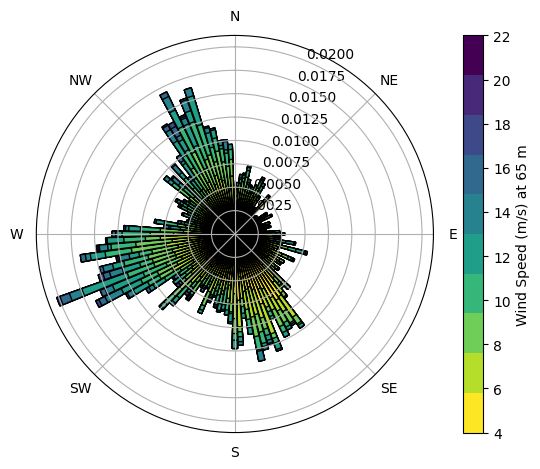

In [6]:
time_series = TimeSeries(
    wind_directions=hybrid_plant.wind._system_model.wind_dirs[0:8760],
    wind_speeds=hybrid_plant.wind._system_model.speeds[0:8760],
    turbulence_intensities=hybrid_plant.wind._system_model.fi.core.flow_field.turbulence_intensities[0]
)

wind_rose = time_series.to_WindRose(wd_edges=np.arange(0, 360, 3.0), ws_edges=np.arange(2.0, 24.0, 2.0))
fig, ax = plt.subplots(subplot_kw={"polar": True})

hub_ht = int(hybrid_plant.site.wind_resource.hub_height_meters)
wind_rose.plot(ax=ax,legend_kwargs={"label": f"Wind Speed (m/s) at {hub_ht} m"})

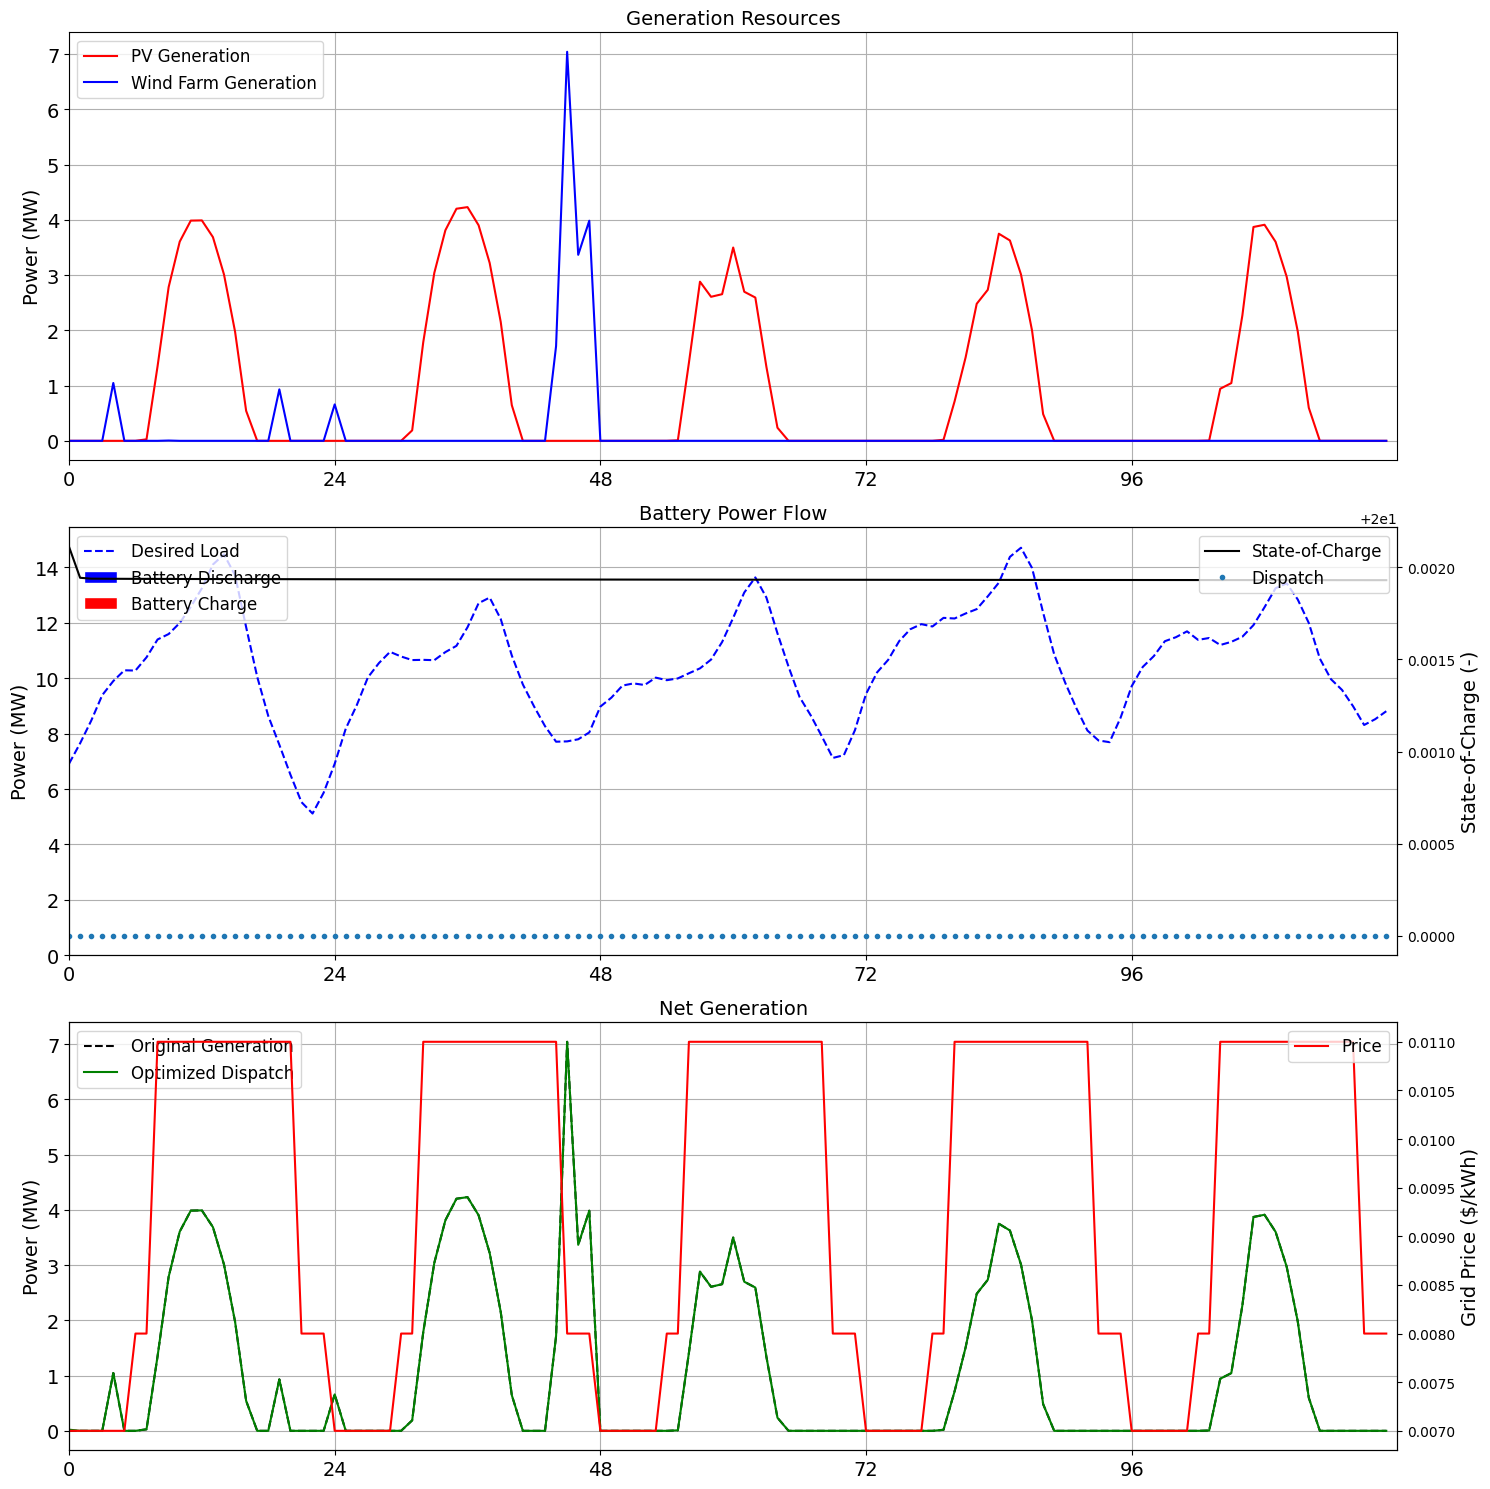

In [7]:
plot_generation_profile(hybrid_plant)